In [13]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import os
import rasterio
from skimage.transform import resize
import json

# Constants
P0 = 0.58  # Base fire spread probability
C1 = 0.045  # Wind coefficient (speed)
C2 = 0.131  # Wind coefficient (direction)
A = 0.078   # Elevation coefficient
GRID_SIZE = 50  # Number of grid points in each direction
MILES_TO_METERS = 1609.34  # 1 mile = 1609.34 meters
RADIUS_METERS = 3 * MILES_TO_METERS  # 10 miles in meters
LAT_CENTER, LON_CENTER = 41.913166, -123.845686  # Simulation center

# Wind (Assumed Constant)
WIND_SPEED = 8  # m/s
WIND_DIRECTION = 315  # Degrees (North-West)

# States
EMPTY = 0
VEGETATION = 1
BURNING = 2
BURNED = 3

# Google Elevation API
GOOGLE_ELEVATION_API = "https://maps.googleapis.com/maps/api/elevation/json"

# Load API Key from config.json
def load_api_keys(config_file="../config.json"):
    if not os.path.exists(config_file):
        raise FileNotFoundError(f"Config file '{config_file}' not found. Create one with your API keys.")
    with open(config_file, "r") as file:
        return json.load(file)

# Load Google Maps API Key
config = load_api_keys()
GOOGLE_API_KEY = config["google_maps_api_key"]

# def get_elevation(lat, lon):
#     """Fetch elevation from Google Maps API"""
#     params = {'locations': f"{lat},{lon}", 'key': GOOGLE_API_KEY}
#     response = requests.get(GOOGLE_ELEVATION_API, params=params).json()
#     if 'results' in response and response['results']:
#         return response['results'][0]['elevation']
#     return 0

def get_elevation(lat, lon):
    """Fetch elevation from Open-Elevation API"""
    url = "https://api.open-elevation.com/api/v1/lookup"
    params = {
        'locations': f"{lat},{lon}"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if 'results' in data and data['results']:
            return data['results'][0]['elevation']
    except Exception as e:
        print(f"Error fetching elevation: {e}")
    return 0

def generate_grid(center_lat, center_lon, grid_size, radius_meters):
    """Generate a grid of lat/lon points within the specified radius"""
    grid = np.zeros((grid_size, grid_size))
    lat_step = (radius_meters * 2) / grid_size / MILES_TO_METERS * 0.0145
    lon_step = lat_step / np.cos(np.radians(center_lat))
    
    lat_grid = np.linspace(center_lat - lat_step * (grid_size // 2), 
                           center_lat + lat_step * (grid_size // 2), grid_size)
    lon_grid = np.linspace(center_lon - lon_step * (grid_size // 2), 
                           center_lon + lon_step * (grid_size // 2), grid_size)

    elevations = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            elevations[i, j] = get_elevation(lat_grid[i], lon_grid[j])
            time.sleep(0.05)  # Avoid exceeding API rate limits

    return lat_grid, lon_grid, elevations

def compute_slope(elevations):
    """Compute slope using elevation differences"""
    slope = np.zeros_like(elevations)
    for i in range(1, elevations.shape[0] - 1):
        for j in range(1, elevations.shape[1] - 1):
            dz_dx = (elevations[i + 1, j] - elevations[i - 1, j]) / 2
            dz_dy = (elevations[i, j + 1] - elevations[i, j - 1]) / 2
            slope[i, j] = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))  # Slope angle in radians
    return np.degrees(slope)  # Convert to degrees

def load_ndvi_and_compute_pveg(ndvi_path, grid_size):
    """Load NDVI GeoTIFF and resample it to match the wildfire simulation grid"""
    with rasterio.open(ndvi_path) as src:
        ndvi = src.read(1)  # Read NDVI band

    # Normalize NDVI to range [0, 1]
    Pveg = (ndvi - np.min(ndvi)) / (np.max(ndvi) - np.min(ndvi))

    # Resample NDVI to match the wildfire simulation grid size
    Pveg_resampled = resize(Pveg, (grid_size, grid_size), mode='reflect', anti_aliasing=True)

    return Pveg_resampled

def calculate_fire_probability(p0, p_veg, p_den, wind_speed, wind_dir, terrain_slope, fire_dir):
    """Calculate probability of fire spreading"""
    theta = np.cos(np.deg2rad(abs(wind_dir - fire_dir)))  # Wind alignment
    P_w = np.exp(C1 * wind_speed) * np.exp(C2 * wind_speed * (theta - 1))  # Wind effect
    P_ele = np.exp(A * terrain_slope)  # Elevation effect
    return p0 * (1 + p_veg) * (1 + p_den) * P_w * P_ele

def initialize_forest(grid_size, vegetation_density=0.7):
    """Initialize vegetation randomly"""
    return np.random.choice([VEGETATION, EMPTY], size=(grid_size, grid_size), p=[vegetation_density, 1 - vegetation_density])

def ignite_fire(grid):
    """Start fire at the center"""
    mid = grid.shape[0] // 2
    grid[mid, mid] = BURNING
    return grid

def plot_fire_simulation(grid, Pveg, step):
    """Plot the wildfire grid with custom colors."""
    # Create a colormap
    cmap = np.zeros((grid.shape[0], grid.shape[1], 3))

    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if grid[x, y] == EMPTY:
                cmap[x, y] = [0, 0, 0]  # Black
            elif grid[x, y] == VEGETATION:
                cmap[x, y] = [0, Pveg[x, y], 0]  # Green varies with Pveg
            elif grid[x, y] == BURNING:
                cmap[x, y] = [1, 0.84, 0]  # Yellow
            elif grid[x, y] == BURNED:
                cmap[x, y] = [1, 1, 1]  # White

    plt.imshow(cmap)
    plt.title(f"Step: {step+1}")
    plt.pause(0.1)

def simulate_fire(grid, elevations, Pveg, steps=50):
    """Simulate wildfire propagation"""
    slope = compute_slope(elevations)
    for step in range(steps):
        new_grid = np.copy(grid)
        for x in range(1, grid.shape[0] - 1):
            for y in range(1, grid.shape[1] - 1):
                if grid[x, y] == BURNING:
                    new_grid[x, y] = BURNED
                    for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                                   (0, -1), (0, 1),
                                   (1, -1), (1, 0), (1, 1)]:
                        nx, ny = x + dx, y + dy
                        if grid[nx, ny] == VEGETATION:
                            fire_dir = np.degrees(np.arctan2(dy, dx))
                            P_burn = calculate_fire_probability(P0, Pveg[nx, ny], 0.3, WIND_SPEED, WIND_DIRECTION, slope[nx, ny], fire_dir)
                            if np.random.rand() < P_burn:
                                new_grid[nx, ny] = BURNING

        grid = np.copy(new_grid)
        plot_fire_simulation(grid, Pveg, step)

    plt.show()


In [14]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.features import rasterize

def load_geojson_polygon(geojson_path):
    """Load fire perimeter polygon from GeoJSON file."""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")  # Assume WGS84 if CRS is missing
    elif gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")  # Convert to WGS84
    return gdf

def create_simulation_mask(grid):
    """Create binary mask for simulated burnt area (BURNED or BURNING cells)."""
    return np.where((grid == BURNED) | (grid == BURNING), 1, 0)

def rasterize_geojson_polygon(gdf, lat_grid, lon_grid, grid_size):
    """Rasterize GeoJSON polygon onto the simulation grid."""
    # Define the transform for rasterization (maps lat/lon to grid indices)
    lat_min, lat_max = lat_grid.min(), lat_grid.max()
    lon_min, lon_max = lon_grid.min(), lon_grid.max()
    
    # Create a transform matrix
    transform = rasterio.transform.from_bounds(
        lon_min, lat_min, lon_max, lat_max, grid_size, grid_size
    )
    
    # Rasterize the polygon(s)
    shapes = [(geom, 1) for geom in gdf.geometry]
    actual_mask = rasterize(
        shapes,
        out_shape=(grid_size, grid_size),
        transform=transform,
        fill=0,  # Background (outside polygon)
        dtype=np.uint8
    )
    
    return actual_mask

def calculate_iou(simulated_mask, actual_mask):
    """Calculate Intersection over Union (IoU) between two binary masks."""
    intersection = np.logical_and(simulated_mask, actual_mask).sum()
    union = np.logical_or(simulated_mask, actual_mask).sum()
    if union == 0:
        return 0.0  # Avoid division by zero
    iou = intersection / union
    return iou

def plot_overlay(simulated_mask, actual_mask, lat_grid, lon_grid, iou):
    """Plot simulated and actual fire areas with IoU."""
    plt.figure(figsize=(10, 8))
    
    # Simulated burnt area (red)
    plt.imshow(simulated_mask, extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()),
               cmap='Reds', alpha=0.5, label='Simulated')
    
    # Actual fire perimeter (blue)
    plt.imshow(actual_mask, extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()),
               cmap='Blues', alpha=0.5, label='Actual')
    
    plt.title(f"Simulated vs Actual Fire Perimeter (IoU: {iou:.3f})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(['Simulated', 'Actual'])
    plt.grid(True)
    plt.show()

def validate_fire_spread(grid, lat_grid, lon_grid, geojson_path):
    """Validate simulated fire spread against GeoJSON fire perimeter."""
    # Load GeoJSON polygon
    gdf = load_geojson_polygon(geojson_path)
    
    # Create binary mask for simulated burnt area
    simulated_mask = create_simulation_mask(grid)
    
    # Rasterize GeoJSON polygon onto the grid
    actual_mask = rasterize_geojson_polygon(gdf, lat_grid, lon_grid, GRID_SIZE)
    
    # Calculate IoU
    iou = calculate_iou(simulated_mask, actual_mask)
    
    # Plot overlay
    plot_overlay(simulated_mask, actual_mask, lat_grid, lon_grid, iou)
    
    return iou

# Example integration with your simulate_fire function
def simulate_fire_with_validation(grid, elevations, Pveg, lat_grid, lon_grid, geojson_path, steps=50):
    """Simulate wildfire and validate against GeoJSON polygon."""
    slope = compute_slope(elevations)
    for step in range(steps):
        new_grid = np.copy(grid)
        for x in range(1, grid.shape[0] - 1):
            for y in range(1, grid.shape[1] - 1):
                if grid[x, y] == BURNING:
                    new_grid[x, y] = BURNED
                    for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                                   (0, -1), (0, 1),
                                   (1, -1), (1, 0), (1, 1)]:
                        nx, ny = x + dx, y + dy
                        if grid[nx, ny] == VEGETATION:
                            fire_dir = np.degrees(np.arctan2(dy, dx))
                            P_burn = calculate_fire_probability(P0, Pveg[nx, ny], 0.3, WIND_SPEED, WIND_DIRECTION, slope[nx, ny], fire_dir)
                            if np.random.rand() < P_burn:
                                new_grid[nx, ny] = BURNING
        grid = np.copy(new_grid)
        plot_fire_simulation(grid, Pveg, step)
    
    # Validate against GeoJSON
    iou = validate_fire_spread(grid, lat_grid, lon_grid, geojson_path)
    print(f"Intersection over Union (IoU): {iou:.3f}")
    
    plt.show()


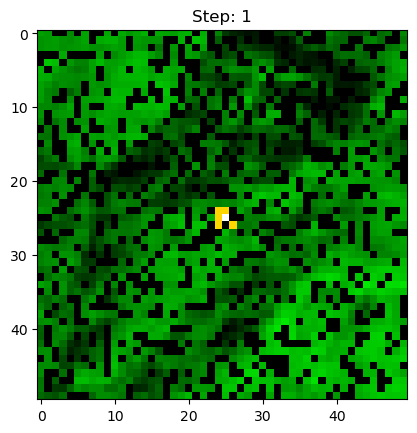

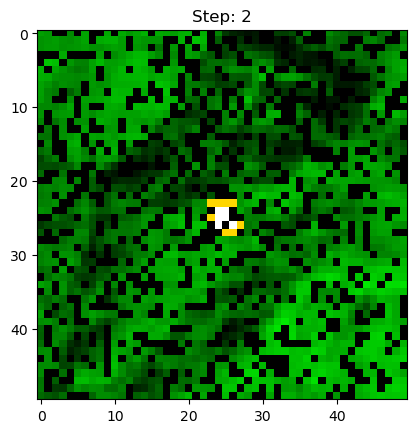

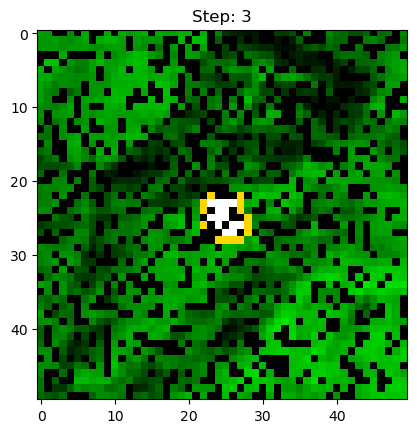

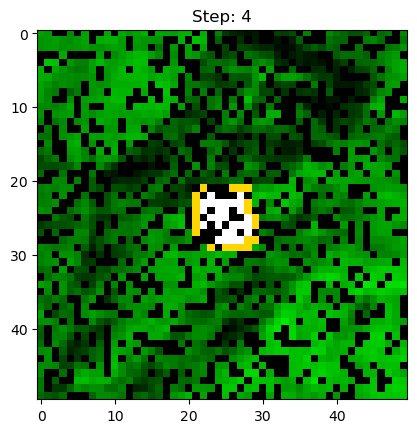

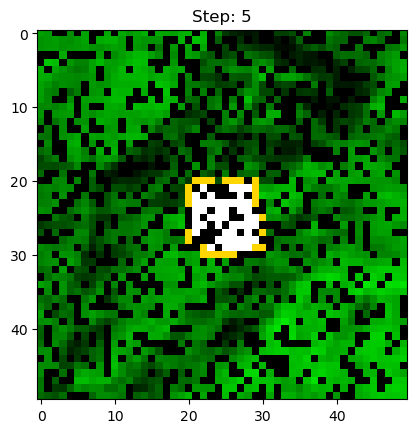

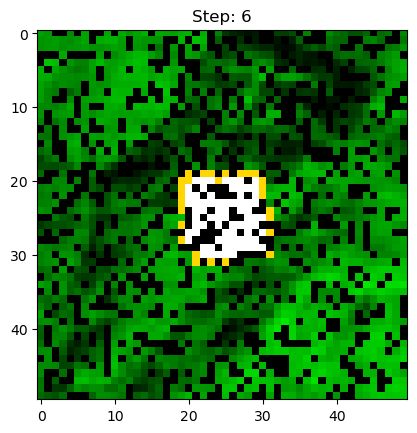

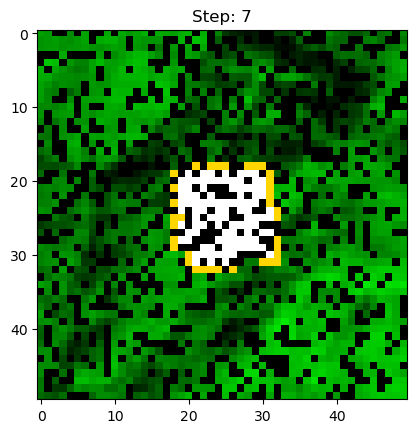

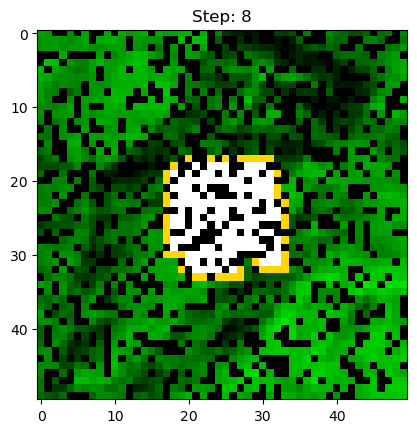

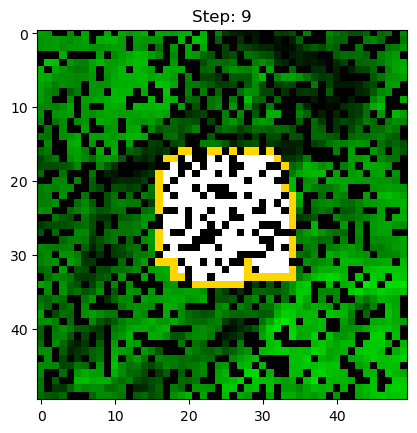

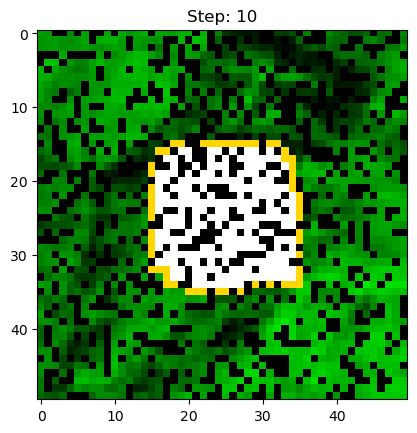

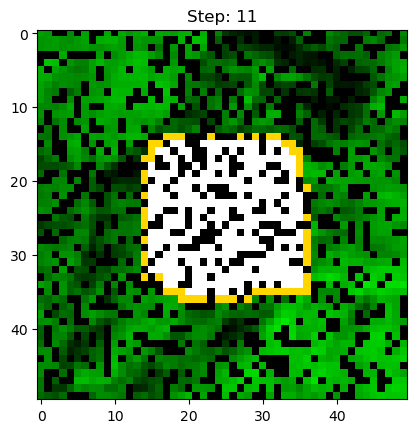

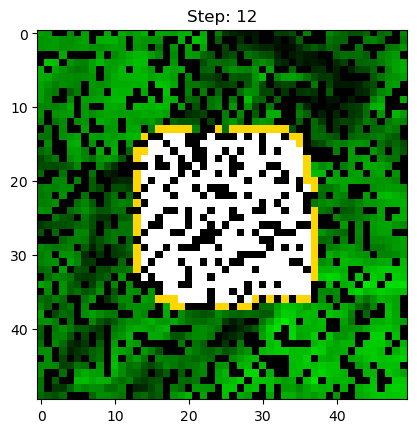

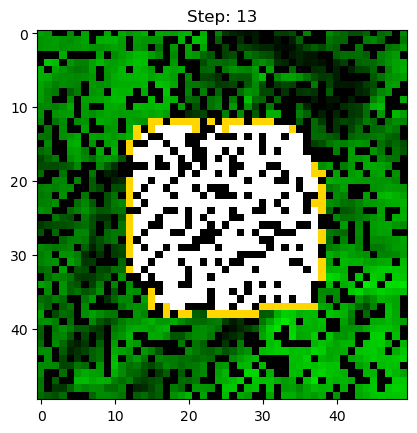

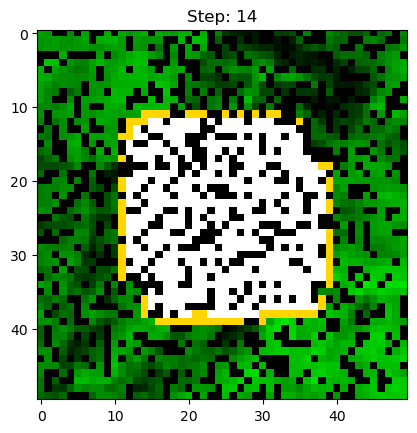

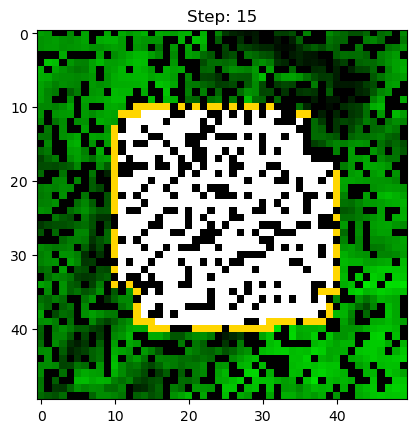

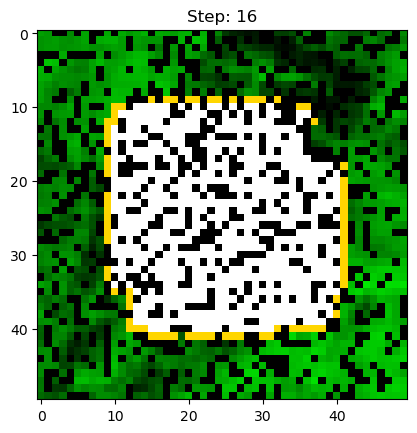

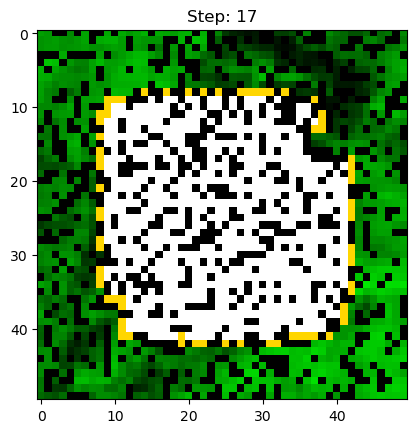

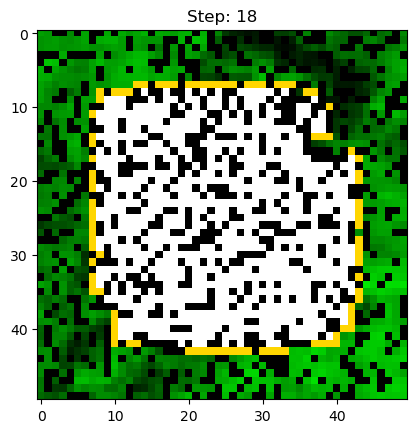

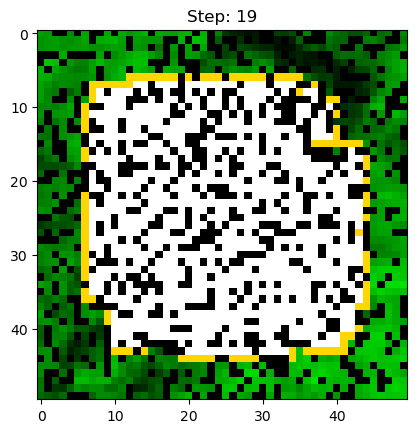

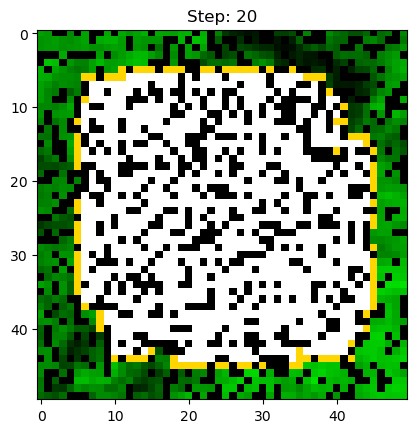

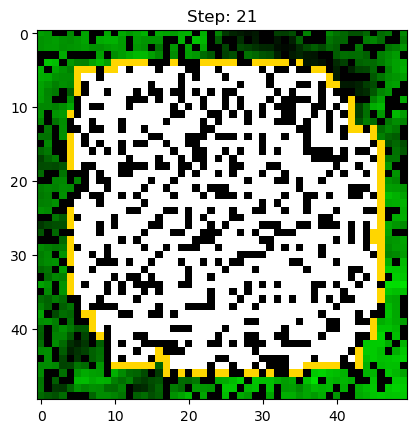

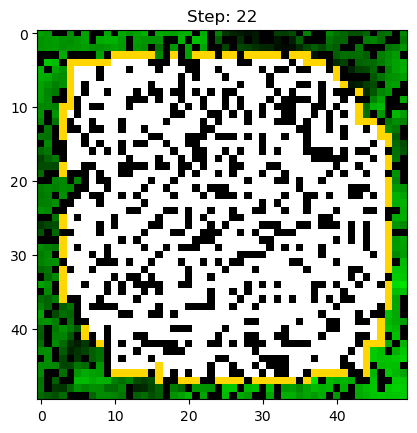

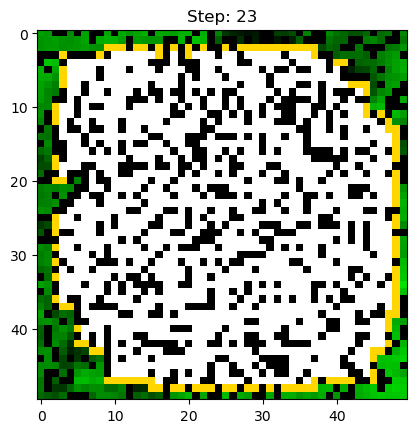

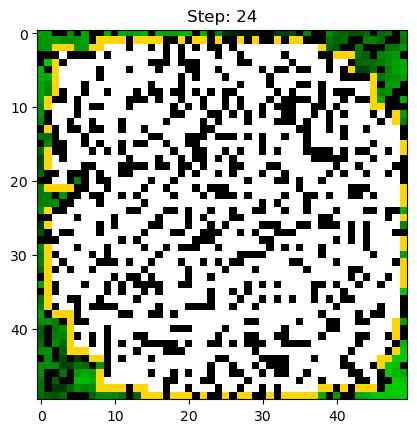

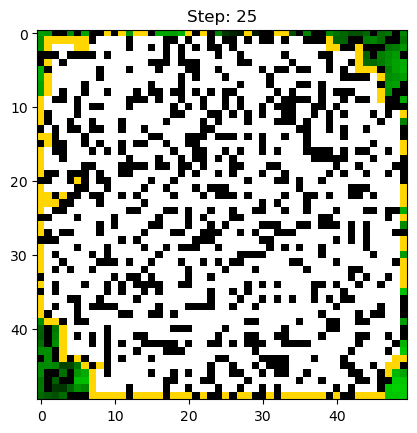

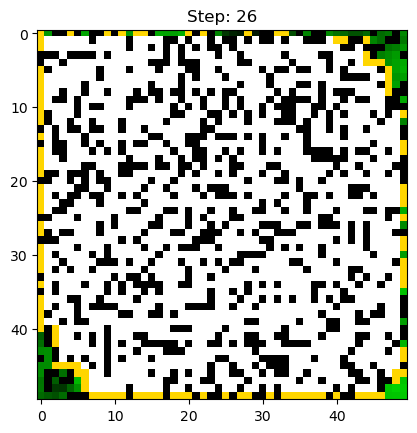

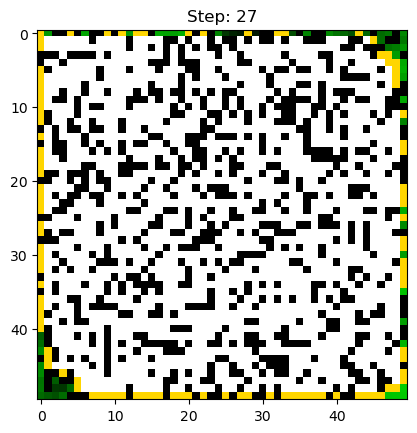

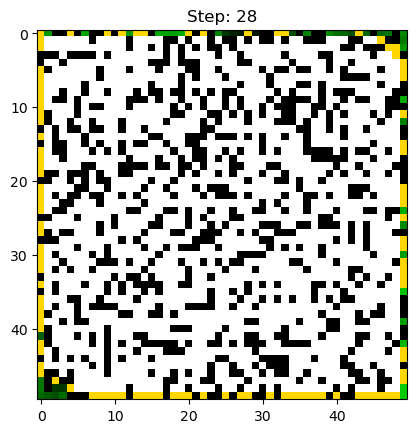

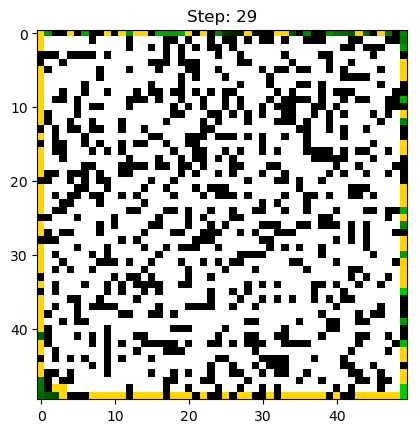

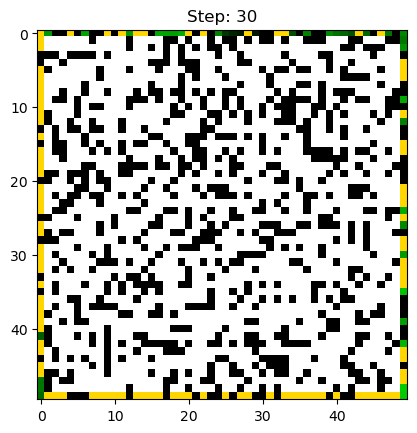

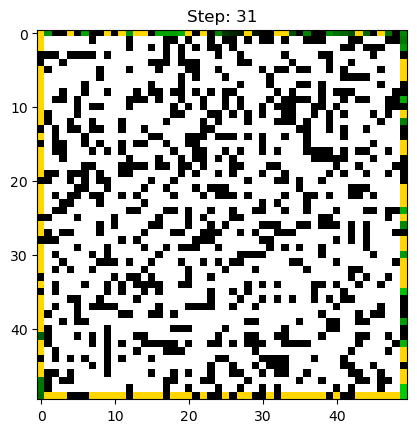

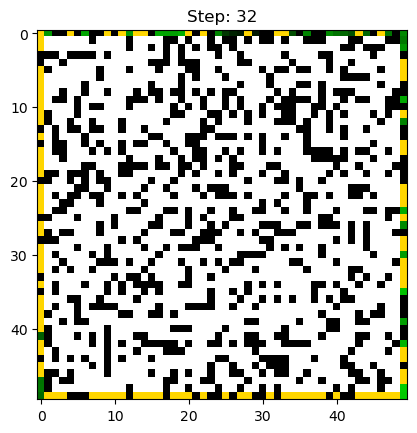

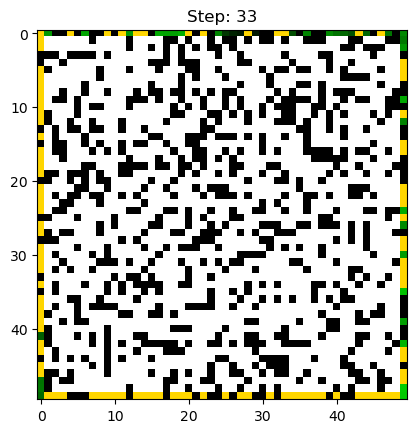

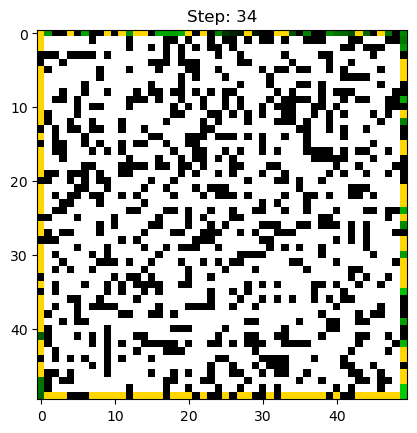

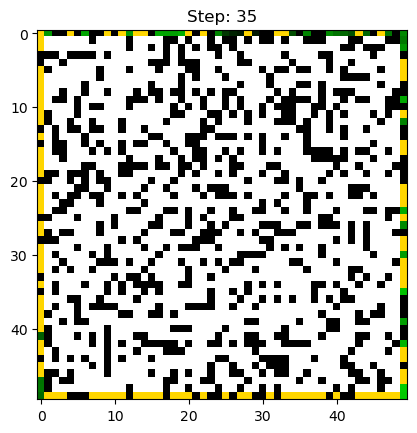

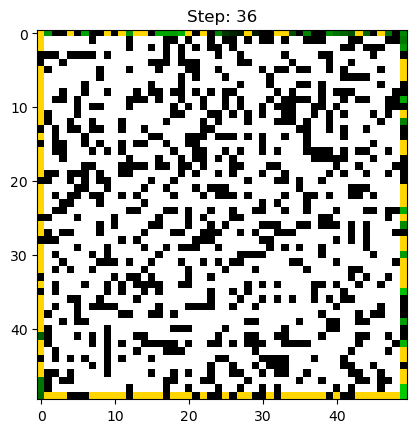

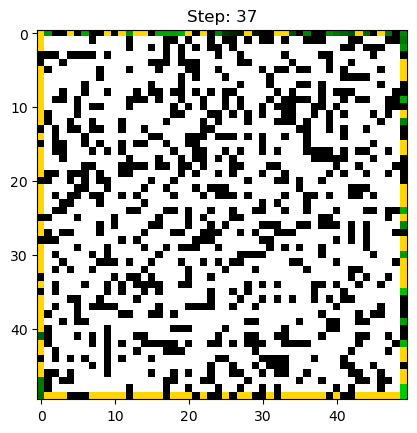

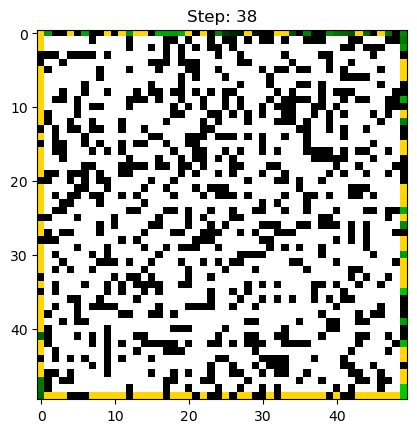

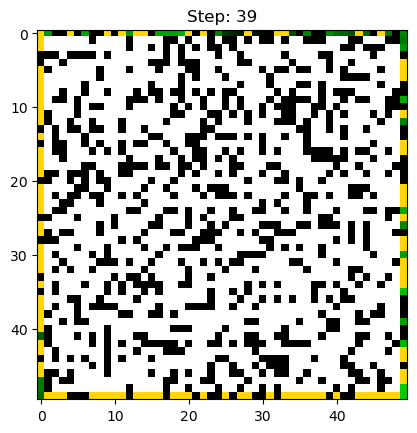

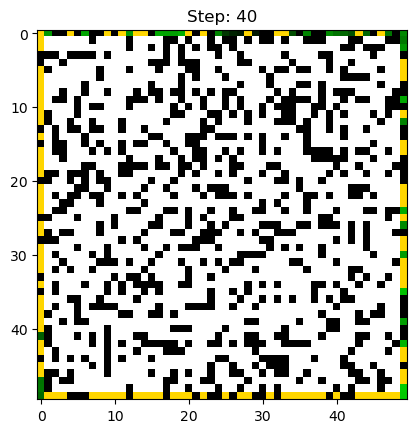

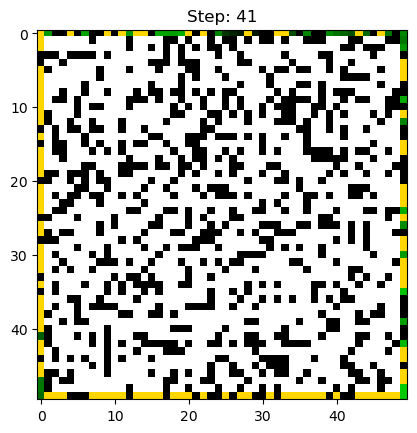

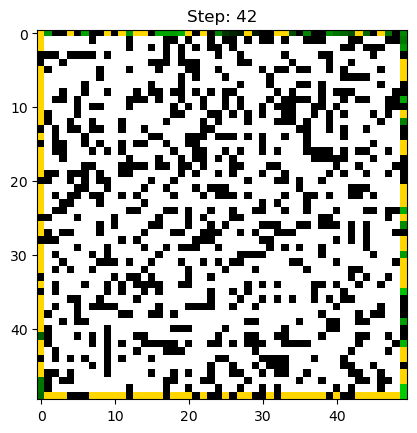

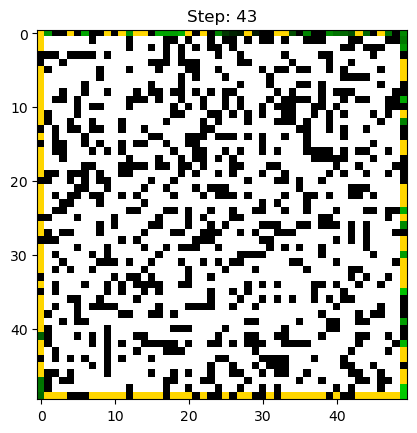

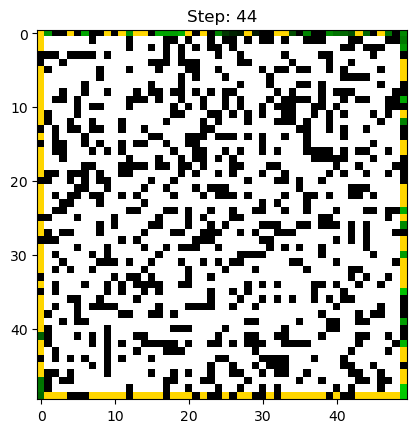

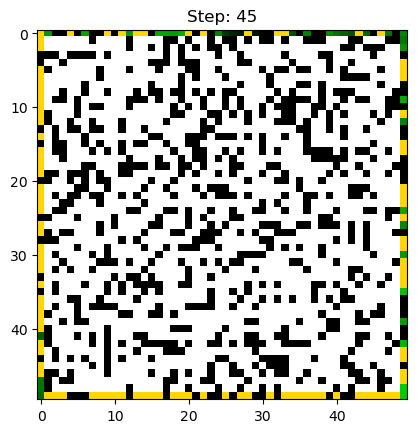

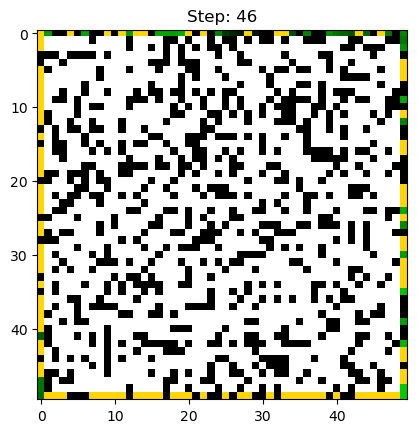

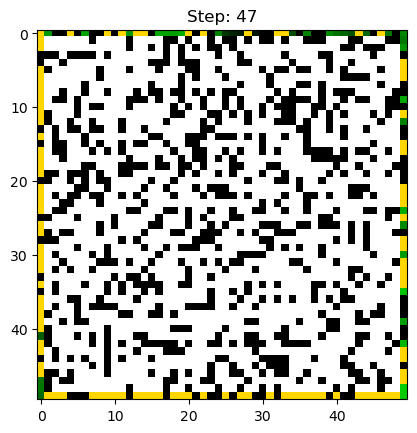

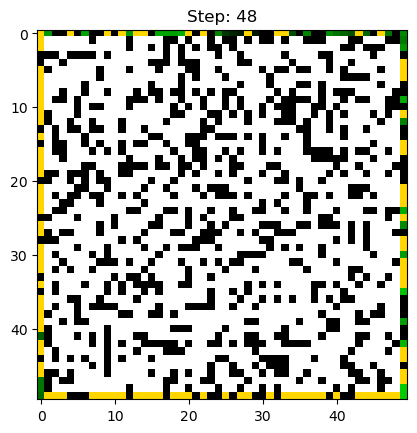

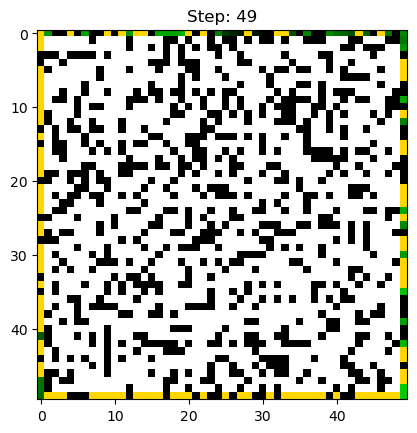

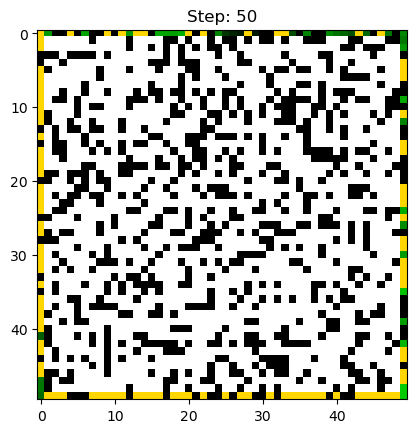

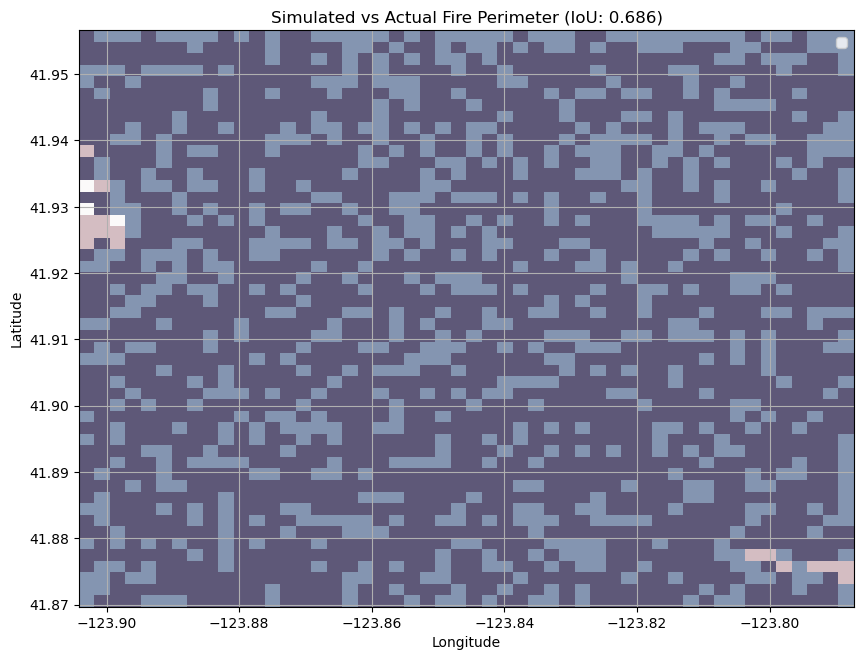

Intersection over Union (IoU): 0.686


In [ ]:
# Generate grid
lat_grid, lon_grid, elevations = generate_grid(LAT_CENTER, LON_CENTER, GRID_SIZE, RADIUS_METERS)

# Load NDVI and compute vegetation probability
ndvi_path = "../data/Kelly_Fire_NDVI.tif"
Pveg = load_ndvi_and_compute_pveg(ndvi_path, GRID_SIZE)

# Initialize forest
grid = initialize_forest(GRID_SIZE)
grid = ignite_fire(grid)

# Path to GeoJSON file
geojson_path = "../data/Kelly_Fire_2023.geojson"

# Run simulation with validation
simulate_fire_with_validation(grid, elevations, Pveg, lat_grid, lon_grid, geojson_path, steps=50)

548.920654296875